Misogynistic text detection with TensorFlow Estimators
===

![nirbhaya](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSG_Exwl5cgaL7gM4y2TCC-qvOHRQWmzBqGQw&usqp=CAU)![feminist_philosophy](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Feminist_philosophy.svg/100px-Feminist_philosophy.svg.png)

This notebook demonstrates how to build a misogynistic text classifier using custom TensorFlow estimators, embeddings and the [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) module. Along the way we'll learn about word2vec and transfer learning as a technique to bootstrap model performance when labeled data is a scarce resource.



### Delving into the Dataset

The data set is composed of **2,285** definitions gathered from the Urban Dictionary platform from 1999 to 2006. The data was classified as `misogynistic` and `non-misogynistic` by three independent researchers with specialized domain knowledge. The data set is essentially a table containing two columns: the text-based definition from Urban Dictionary and its respective classification; label **1** for `misogynistic` and label **0** for `non-misogynistic` text.

![#f03c15](https://via.placeholder.com/15/f03c15/000000?text=+) **Content warning: sexual violence, extreme misogyny, scatology, ‘scat porn’.**

#### Credits

*Lynn, Theodore; Endo, Patricia; Rosati, Pierangelo; Silva, Ivanovitch; Santos, Guto Leoni; Ging, Debbie (2019) “Urban Dictionary definitions dataset for misogyny speech detection”, Mendeley Data, v3*

https://data.mendeley.com/datasets/3jfwsdkryy/3

# Convert dataset to a Pandas DataFrame, fill NaNs, and sanitize types

In [12]:
!wget --quiet https://raw.githubusercontent.com/cloudxlab/misogynistic-text-detector/main/tagged_misogynistic_text.csv

In [14]:
import pandas as pd
import numpy as np

misogynistic_df = pd.read_csv('tagged_misogynistic_text.csv', encoding = 'ISO-8859-1')

In [15]:
misogynistic_df = misogynistic_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['is_misogyny'], how='all')

In [16]:
misogynistic_df['is_misogyny'] = misogynistic_df['is_misogyny'].astype(int)

## Word cloud grid with `safe` and `misogynistic` text

In [18]:
%%capture 

!pip install wordcloud

In [19]:
from wordcloud import WordCloud

In [20]:
misogynistic_text = misogynistic_df.where(misogynistic_df['is_misogyny'] == 1)['Definition'].values
safe_text = misogynistic_df.where(misogynistic_df['is_misogyny'] == 0)['Definition'].values

misogynistic_wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = '#ff5c5c').generate(str(misogynistic_text))

safe_wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = '#addfad').generate(str(safe_text))


In [21]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

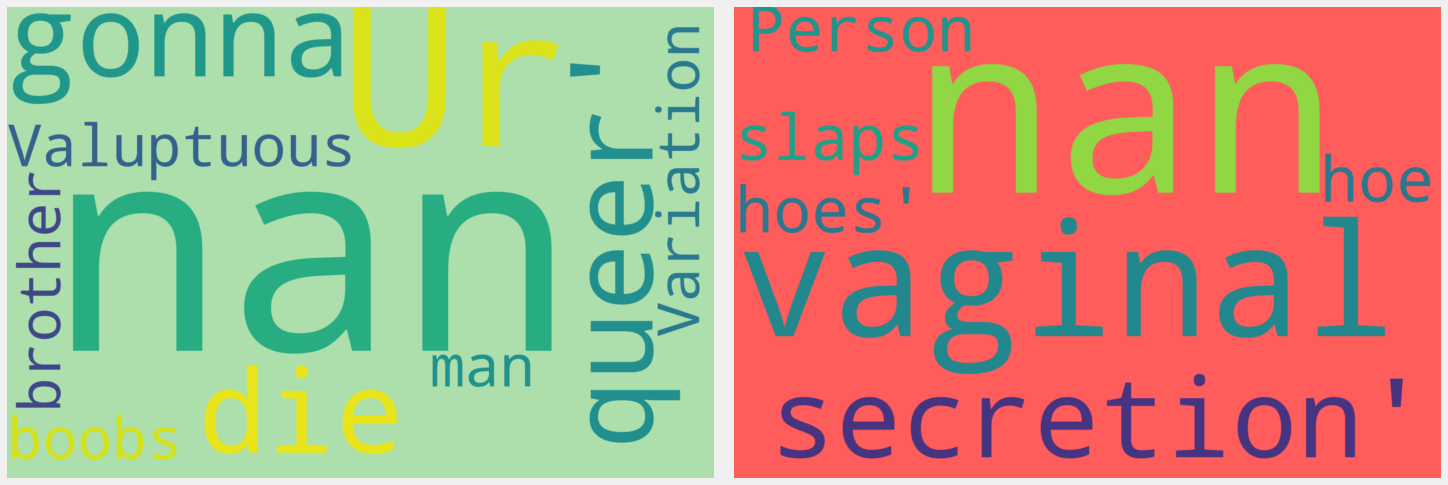

In [22]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=[20, 10])

spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])

ax0.imshow(safe_wordcloud, interpolation = 'bilinear')
ax0.axis('off')

ax1.imshow(misogynistic_wordcloud, interpolation = 'bilinear')
ax1.axis('off')

fig.show()

# Installing the BERT tokenization library and defining helper encoding routines

In [23]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [24]:
%%capture

!pip install sentencepiece

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K

# Import the tokenization library that we just fetched
import tokenization

In [26]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Build and train the model

In [27]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name='segment_ids')

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    cls_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Download pre-trained cased english BERT that we will be transfer learning from 

In [28]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 17.9 s, sys: 3.93 s, total: 21.9 s
Wall time: 29.4 s


In [29]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [30]:
model = build_model(bert_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [33]:
misogynistic_df.columns

Index(['Definition', 'is_misogyny'], dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
x_train, x_test, y_train, y_test = train_test_split(misogynistic_df['Definition'], misogynistic_df['is_misogyny'], test_size=0.20, random_state=42)
train_input = bert_encode(x_train, tokenizer)

history = model.fit(
    train_input, y_train,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=32,
)

In [ ]:
test_input = bert_encode(x_test)
model.load_weights('model.h5')
test_pred = model.predict(test_input)